In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast
import json
import re
import os
import seaborn as sns
import collections, functools, operator
from sklearn.model_selection import train_test_split
import re
import nltk
import string


import nltk
from nltk.corpus import stopwords
from nltk import tokenize
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score
import contractions

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/alina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/alina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/alina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## EDA

Считываем трейновые данные:

In [2]:
train = pd.read_csv("/Users/alina/Desktop/vk_internship/train_spam.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB


In [4]:
train.describe()

,text_type,text
count,16278,16278
unique,2,16267
top,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
freq,11469,7


Проверим, есть ли пустые значения:

In [5]:
train.isnull().sum()

text_type    0
text         0
dtype: int64

Пустых значений нет. Проверим наличие дубликатов:

In [6]:
train[train.duplicated()]

,text_type,text
4145,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
4463,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
5640,ham,/ban
6933,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
7663,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
7918,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
9790,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
10290,ham,SPAM DETECTION User: Username: @DillyBubb...
10811,ham,SPAM DETECTION User: Username: @DillyBubb...
13210,ham,SPAM DETECTION User: Username: @DillyBubb...


Удалим дубликаты, чтобы в дальнейшем это не ухудшило перформанс моделей

In [7]:
train = train.drop_duplicates()

In [8]:
train[train.duplicated()]

,text_type,text


Посмотрим на статистику соотношения классов. Видим, что сильного дисбаланса классов нет

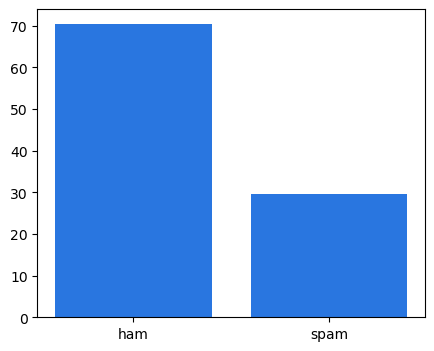

In [10]:
fig, ax = plt.subplots(ncols=1, figsize=(5, 4))
ax.bar(train['text_type'].unique(), [100*len(train.loc[train['text_type'] == 'ham'])/len(train), 100*len(train.loc[train['text_type'] == 'spam'])/len(train)], color='#2976E0')
plt.show()

In [11]:
# Создадим информационный датасет для хранения статистики о текстовых данных

train_info = pd.DataFrame()

# Определим функцию подсчета слов

def word_count(text):
    text_list = text.split()
    return len(text_list)

In [12]:
# Подсчитаем длину текстов в символах, число слов в тексте, среднюю длину слова в тексте
# Укажем усредненные показатели по датасету


train_info['text_length'] = train['text'].str.len()
train_info['text_word_count'] = train['text'].apply(word_count)
train_info['text_mean_word_length'] = train['text'].map(lambda text: np.mean([len(word) for word in text.split()]))

train_info

,text_length,text_word_count,text_mean_word_length
0,86,16,4.437500
1,520,97,4.371134
2,126,22,4.772727
3,139,23,5.086957
4,733,127,4.779528
...,...,...,...
16273,114,18,5.388889
16274,454,73,5.232877
16275,799,147,4.442177
16276,102,21,3.904762


In [13]:
print("Среднее число знаков в тексте: {}".format(train_info['text_length'].mean()))
print("Среднее количество слов в тексте: {}".format(train_info['text_word_count'].mean()))
print("Средняя длина слов в тексте: {}".format(train_info['text_mean_word_length'].mean()))

Среднее число знаков в тексте: 310.4689862912645
Среднее количество слов в тексте: 56.840167209688325
Средняя длина слов в тексте: 4.442531267330611


In [14]:
print("Минимальное число знаков в тексте: {}".format(min(train_info['text_length'])))
print("Минимальное количество слов в тексте: {}".format(min(train_info['text_word_count'])))
print("Минимальная длина слов в тексте: {}".format(min(train_info['text_mean_word_length'])))

Минимальное число знаков в тексте: 1
Минимальное количество слов в тексте: 1
Минимальная длина слов в тексте: 1.0


In [172]:
print("Максимальное число знаков в тексте: {}".format(max(train_info['text_length'])))
print("Максимальное количество слов в тексте: {}".format(max(train_info['text_word_count'])))
print("Максимальная длина слов в тексте: {}".format(max(train_info['text_mean_word_length'])))

Максимальное число знаков в тексте: 800
Максимальное количество слов в тексте: 206
Максимальная длина слов в тексте: 79.1


Видим, что есть выбросы: тексты, которые состоят только из одного символа, и тексты, которые состоят из набора символов без пробела

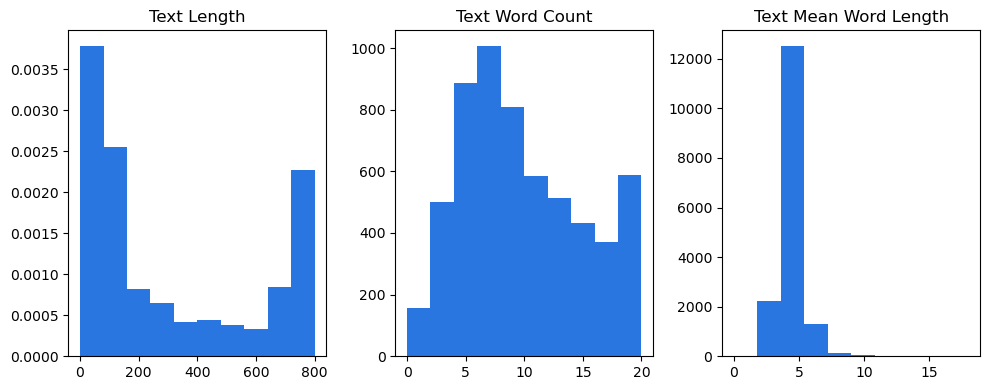

In [15]:
# Проиллюстрируем найденные показатели

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

ax0.hist(train_info['text_length'], density=True, histtype='bar', color='#2976E0')
ax0.set_title('Text Length')

ax1.hist(train_info['text_word_count'], range=[0, 20], histtype='bar', color='#2976E0' )
ax1.set_title('Text Word Count')

ax2.hist(train_info['text_mean_word_length'],  range=[0, 18], histtype='bar', color='#2976E0')
ax2.set_title('Text Mean Word Length')

fig.tight_layout()
plt.show()

Посмотрим на соотношение длин текстов и количества слов в зависимости от классов:

/var/folders/6v/s1fs_26158db7chz49zh63hc0000gn/T/ipykernel_41136/1112906982.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ham, label='Ham')
/Users/alina/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/6v/s1fs_26158db7chz49zh63hc0000gn/T/ipykernel_41136/1112906982.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(spam, label='Spam')
/Users/alina/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


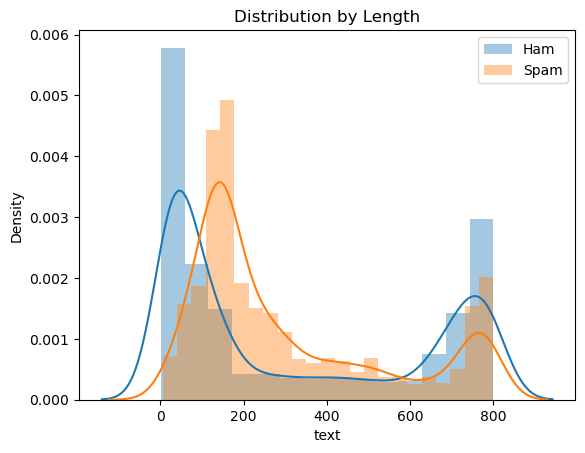

In [16]:
ham = train[train['text_type'] == 'ham']['text'].str.len()
sns.distplot(ham, label='Ham')

spam = train[train['text_type'] == 'spam']['text'].str.len()
sns.distplot(spam, label='Spam')

plt.title('Distribution by Length')
plt.legend()

/var/folders/6v/s1fs_26158db7chz49zh63hc0000gn/T/ipykernel_41136/4234890128.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ham1, label='Ham')
/Users/alina/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/6v/s1fs_26158db7chz49zh63hc0000gn/T/ipykernel_41136/4234890128.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a

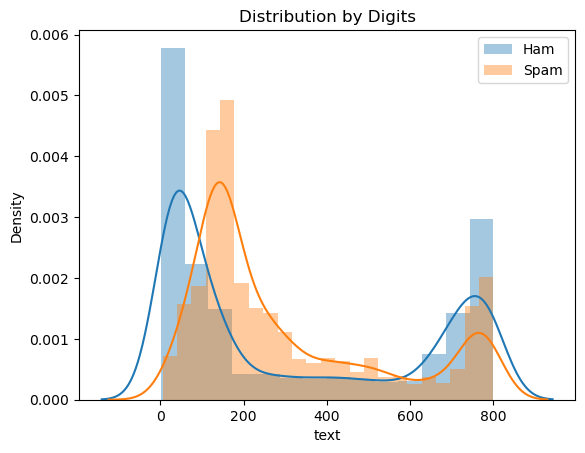

In [17]:
ham1 = train[train['text_type'] == 'ham']['text'].str.replace(r'\D+', '').str.len()
sns.distplot(ham1, label='Ham')

spam1 = train[train['text_type'] == 'spam']['text'].str.replace(r'\D+', '').str.len()
sns.distplot(spam1, label='Spam')

plt.title('Distribution by Digits')
plt.legend()

/var/folders/6v/s1fs_26158db7chz49zh63hc0000gn/T/ipykernel_41136/1039366697.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ham2, label='Ham')
/Users/alina/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/6v/s1fs_26158db7chz49zh63hc0000gn/T/ipykernel_41136/1039366697.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a

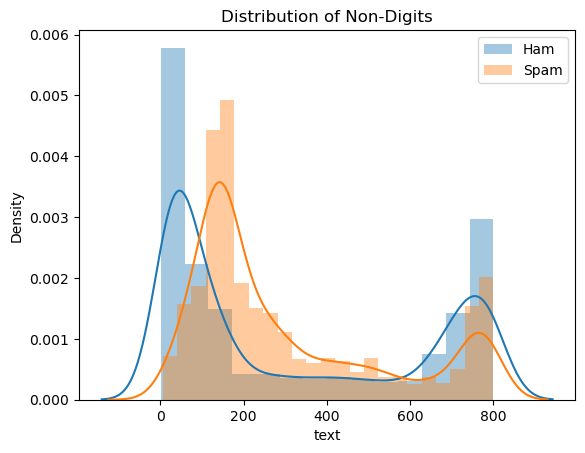

In [20]:
ham2 = train[train['text_type'] == 'ham']['text'].str.replace(r'\w+', '').str.len()
sns.distplot(ham2, label='Ham')

spam2 = train[train['text_type'] == 'spam']['text'].str.replace(r'\w+', '').str.len()
sns.distplot(spam2, label='Spam')

plt.title('Distribution of Non-Digits')
plt.legend()

In [ ]:
Проведем предобработку: токенизация, приведение слов к нижнему регистру, удаление стоп-слов, цифр, эмодзи, и других символов, которые
впоследствии не сможем закодировать

In [54]:

stopwords = stopwords.words('english')
stopwords.extend(['1635465'])

AttributeError: 'list' object has no attribute 'words'

In [55]:
train['preprocessed'] = train['text'].apply(lambda s: nltk.word_tokenize(s))
train['preprocessed'] = train['preprocessed'] .apply(lambda str: [c.lower() for c in str if c.isalpha()])
train['preprocessed'] = train['preprocessed'] .apply(lambda str: [w for w in str if w not in stopwords])

In [56]:
train

,text_type,text,preprocessed,lemmatized
0,ham,make sure alex knows his birthday is over in f...,"[make, sure, alex, knows, birthday, fifteen, m...","[m, a, k, e, s, u, r, e, a, l, e, x, k, n, o, ..."
1,ham,a resume for john lavorato thanks vince i will...,"[resume, john, lavorato, thanks, vince, get, m...","[r, e, s, u, m, e, j, o, h, n, l, a, v, o, r, ..."
2,spam,plzz visit my website moviesgodml to get all m...,"[plzz, visit, website, moviesgodml, get, movie...","[p, l, z, z, v, i, s, i, t, w, e, b, s, i, t, ..."
3,spam,urgent your mobile number has been awarded wit...,"[urgent, mobile, number, awarded, prize, guara...","[u, r, g, e, n, t, m, o, b, i, l, e, n, u, m, ..."
4,ham,overview of hr associates analyst project per ...,"[overview, hr, associates, analyst, project, p...","[o, v, e, r, v, i, e, w, h, r, a, s, s, o, c, ..."
...,...,...,...,...
16273,spam,if you are interested in binary options tradin...,"[interested, binary, options, trading, may, co...","[i, n, t, e, r, e, s, t, e, d, b, i, n, a, r, ..."
16274,spam,dirty pictureblyk on aircel thanks you for bei...,"[dirty, pictureblyk, aircel, thanks, valued, m...","[d, i, r, t, y, p, i, c, t, u, r, e, b, l, y, ..."
16275,ham,or you could do this g on mon 1635465 sep 1635...,"[could, g, mon, sep, david, rees, wrote, mon, ...","[c, o, u, l, d, g, m, o, n, s, e, p, d, a, v, ..."
16276,ham,insta reels par 80 गंद bhara pada hai 👀 kuch b...,"[insta, reels, par, bhara, pada, hai, kuch, bh...","[i, n, s, t, a, r, e, e, l, s, p, a, r, b, h, ..."


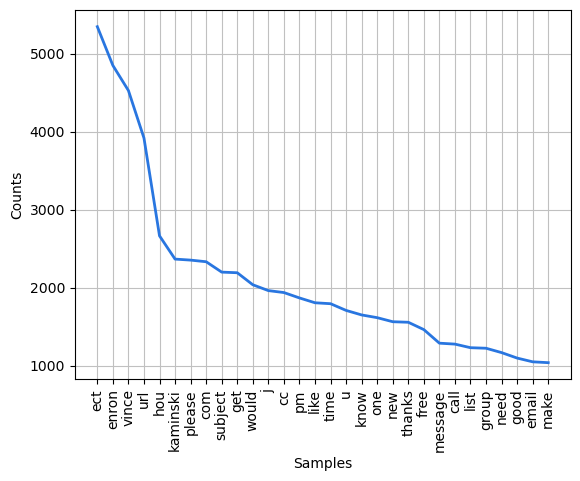

<Axes: xlabel='Samples', ylabel='Counts'>

In [35]:
# Иллюстрируем частотность слов всего датасета

tfa_train_merged = []
for word_list in train['preprocessed']:
    tfa_train_merged += word_list
    
fdist = FreqDist(tfa_train_merged)
fdist.plot(30, cumulative=False, color='#2976E0')

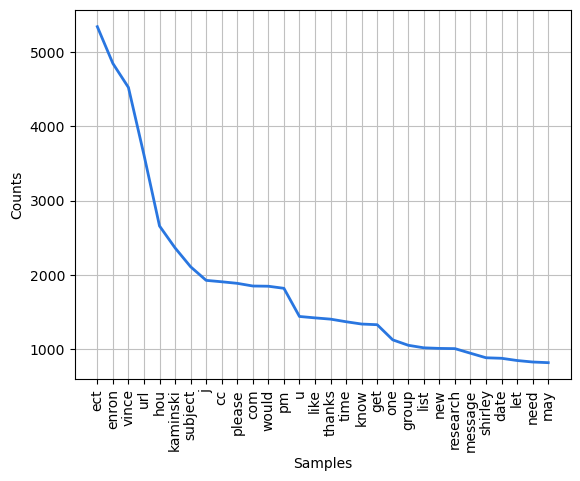

<Axes: xlabel='Samples', ylabel='Counts'>

In [40]:
# 30 самых частых слов не-спама

ham_merged = []
for word_list in train['preprocessed'].loc[train['text_type']=='ham']:
    ham_merged += word_list
    
fdist_ham = FreqDist(ham_merged)
fdist_ham.plot(30, cumulative=False, color='#2976E0')

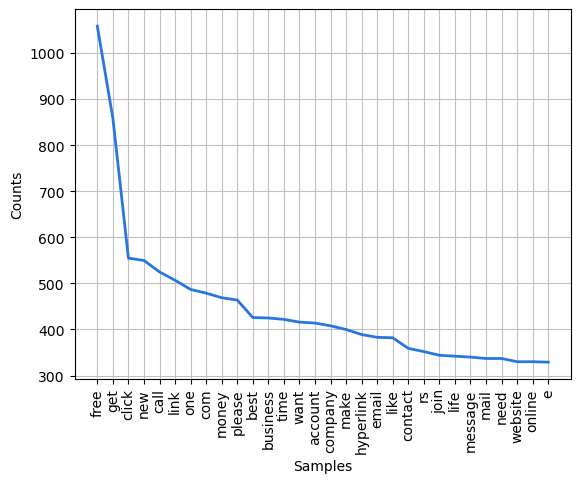

<Axes: xlabel='Samples', ylabel='Counts'>

In [41]:
# 30 самых частых слов спама

spam_merged = []
for word_list in train['preprocessed'].loc[train['text_type']=='spam']:
    spam_merged += word_list
    
fdist_spam = FreqDist(spam_merged)
fdist_spam.plot(30, cumulative=False, color='#2976E0')

После анализа частотности предобработаем тестовый датасет и лемматизируем данные

In [57]:
# Лемматизация

train['preprocessed'] = train['preprocessed'].apply(lambda s: ' '.join(s))

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text)]


[nltk_data] Downloading package wordnet to /Users/alina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [67]:

train['lemmatized'] = train['preprocessed'].apply(lemmatize_text)
train['lemmatized'] = train['lemmatized'].apply(lambda s: ' '.join(s))

In [68]:
train['lemmatized']

0        make sure alex know birthday fifteen minute fa...
1        resume john lavorato thanks vince get moving r...
2        plzz visit website moviesgodml get movie free ...
3        urgent mobile number awarded prize guaranteed ...
4        overview hr associate analyst project per davi...
                               ...                        
16273    interested binary option trading may continue ...
16274    dirty pictureblyk aircel thanks valued member ...
16275    could g mon sep david rees wrote mon sep rob w...
16276    insta reel par bhara pada hai kuch bhi dalte c...
16277    alex paper comment sentence eqn eqn think annu...
Name: lemmatized, Length: 16267, dtype: object

In [69]:
X_train, X_test, y_train, y_test = train_test_split(train['lemmatized'], train['text_type'], test_size=0.33, random_state=42)

Протестируем 3 метода кодирования предложений - CountVectorizer, Tf-Idf, BERT Word Embeddings
И 7 алгоритмов классического МЛ - Наивный Байес, Метод Опорных Векторов, К ближайших соседей, Решающие деревья, Случайный лес, Бустинг и Бэггинг (некоторые алгоритмы опустим при проверке BERT Word Embeddings из-за неподходящего инпута)
Опираясь на ROC-AUC, указанную в задании, вычислим наилучший алгоритм


In [70]:
y_train.replace({'ham': 0, 'spam': 1}, inplace=True)
y_test.replace({'ham': 0, 'spam': 1}, inplace=True)

Count Vectorizer: 

In [71]:
cv = CountVectorizer(max_features = 1500)
cv.fit(X_train)
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

In [72]:
mnb1 = MultinomialNB(alpha = 0.5)
mnb1.fit(X_train_cv, y_train)

y_mnb1 = mnb1.predict(X_test_cv)
print('Naive Bayes ROC-AUC: ', roc_auc_score(y_mnb1, y_test))

Naive Bayes ROC-AUC:  0.8519702161307325


In [73]:
svc1 = SVC(kernel='sigmoid', gamma=1.0)
svc1.fit(X_train_cv,y_train)
y_svc1 = svc1.predict(X_test_cv)
print('SVM ROC-AUC: ', roc_auc_score(y_svc1, y_test))

SVM ROC-AUC:  0.6885978280747895


In [75]:
knc1 = KNeighborsClassifier(n_neighbors=100)
knc1.fit(X_train_cv,y_train)

y_knc1 = knc1.predict(X_test_cv)
print('KNeighbors ROC-AUC: ', roc_auc_score(y_knc1, y_test))

KNeighbors ROC-AUC:  0.8296810610852356


In [76]:
dtc1 = DecisionTreeClassifier(min_samples_split=7)
dtc1.fit(X_train_cv,y_train)
y_dtc1 = dtc1.predict(X_test_cv)
print('Decision Tree ROC-AUC: ', roc_auc_score(y_dtc1, y_test))

Decision Tree ROC-AUC:  0.8724759022329092


In [77]:
rfc1 = RandomForestClassifier(n_estimators=75, random_state=252)
rfc1.fit(X_train_cv,y_train)
y_rfc1 = rfc1.predict(X_test_cv)
print('Random Forest ROC-AUC: ', roc_auc_score(y_rfc1, y_test))

Random Forest ROC-AUC:  0.920784876932418


In [78]:
abc1 = AdaBoostClassifier(n_estimators=37, random_state=252)
abc1.fit(X_train_cv,y_train)
y_abc1 = abc1.predict(X_test_cv)
print('Adaptable Boosting ROC-AUC: ', roc_auc_score(y_abc1, y_test))

/Users/alina/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Adaptable Boosting ROC-AUC:  0.854249758278946


In [79]:
bc1 = BaggingClassifier(n_estimators=9, random_state=252)
bc1.fit(X_train_cv,y_train)
y_bc1 = bc1.predict(X_test_cv)
print('Bagging ROC-AUC: ', roc_auc_score(y_bc1, y_test))

Bagging ROC-AUC:  0.8791002760670461


In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer()
tf_idf.fit(X_train)
X_train_tfidf = tf_idf.transform(X_train)
X_test_tfidf = tf_idf.transform(X_test)

In [81]:
mnb2 = MultinomialNB(alpha = 0.5)
mnb2.fit(X_train_tfidf, y_train)

y_mnb2 = mnb2.predict(X_test_tfidf)
print('Naive Bayes ROC-AUC: ', roc_auc_score(y_mnb2, y_test))

Naive Bayes ROC-AUC:  0.9031571581101804


In [82]:
svc2 = SVC(kernel='sigmoid', gamma=1.0)
svc2.fit(X_train_tfidf, y_train)
y_svc2 = svc2.predict(X_test_tfidf)
print('SVM ROC-AUC: ', roc_auc_score(y_svc2, y_test))

SVM ROC-AUC:  0.9271349510773474


In [83]:
knc2 = KNeighborsClassifier(n_neighbors=100)
knc2.fit(X_train_tfidf, y_train)

y_knc2 = knc2.predict(X_test_tfidf)
print('KNeighbors ROC-AUC: ', roc_auc_score(y_knc2, y_test))

KNeighbors ROC-AUC:  0.8645762133335158


In [84]:
rfc2 = RandomForestClassifier(n_estimators=37, random_state=252)
rfc2.fit(X_train_tfidf, y_train)
y_rfc2 = rfc2.predict(X_test_tfidf)
print('Random Forest ROC-AUC: ', roc_auc_score(y_rfc2, y_test))

Random Forest ROC-AUC:  0.9377406813893288


In [85]:
abc2 = AdaBoostClassifier(n_estimators=37, random_state=252)
abc2.fit(X_train_tfidf, y_train)
y_abc2 = abc2.predict(X_test_tfidf)
print('Adaptable Boosting ROC-AUC: ', roc_auc_score(y_abc2, y_test))

/Users/alina/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Adaptable Boosting ROC-AUC:  0.8496534141445652


In [89]:
bc2 = BaggingClassifier(n_estimators=9, random_state=252)
bc2.fit(X_train_tfidf, y_train)
y_bc2 = bc2.predict(X_test_tfidf)
print('Bagging ROC-AUC: ', roc_auc_score(y_bc2, y_test))

Bagging ROC-AUC:  0.9046313547819255


In [87]:
from sentence_transformers import SentenceTransformer
bert = SentenceTransformer('bert-base-nli-mean-tokens')

Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized



In [90]:
X_train_bert_matrix = X_train.apply(lambda string: bert.encode(string))
X_test_bert_matrix = X_test.apply(lambda string: bert.encode(string))

In [92]:
feature_train = [x for x in X_train_bert_matrix]
X_train_bert = np.asarray(feature_train)

feature_test = [x for x in X_test_bert_matrix]
X_test_bert = np.asarray(feature_test)


In [94]:
svc3 = SVC(kernel='sigmoid', gamma=1.0)
svc3.fit(X_train_bert, y_train)
y_svc3 = svc3.predict(X_test_bert)
print('SVM ROC-AUC: ', roc_auc_score(y_svc3, y_test))

SVM ROC-AUC:  0.4779994931836214


In [96]:
rfc3 = RandomForestClassifier(n_estimators=75, random_state=252)
rfc3.fit(X_train_bert, y_train)
y_rfc3 = rfc3.predict(X_test_bert)
print('Random Forest ROC-AUC: ', roc_auc_score(y_rfc3, y_test))

Random Forest ROC-AUC:  0.8929919799115497


In [98]:
abc3 = AdaBoostClassifier(n_estimators=37, random_state=252)
abc3.fit(X_train_bert, y_train)
y_abc3 = abc3.predict(X_test_bert)
print('Adaptable Boosting ROC-AUC: ', roc_auc_score(y_abc3, y_test))

/Users/alina/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Adaptable Boosting ROC-AUC:  0.8336311490445463


In [99]:
bc3 = BaggingClassifier(n_estimators=9, random_state=252)
bc3.fit(X_train_bert, y_train)
y_bc3 = bc3.predict(X_test_bert)
print('Bagging ROC-AUC: ', roc_auc_score(y_bc3, y_test))

Bagging ROC-AUC:  0.8432026606950097


Обработка тестового датасета и скоринг:

In [102]:
test = pd.read_csv("/Users/alina/Desktop/vk_internship/test_spam.csv")

In [103]:

test['preprocessed'] = test['text'].apply(lambda s: nltk.word_tokenize(s))
test['preprocessed'] = test['preprocessed'] .apply(lambda str: [c.lower() for c in str if c.isalpha()])
test['preprocessed'] = test['preprocessed'] .apply(lambda str: [w for w in str if w not in stopwords])
test['preprocessed'] = test['preprocessed'].apply(lambda s: ' '.join(s))

In [104]:
test['preprocessed']

0       j jim whitehead ejw cse ucsc edu writes j open...
1       original message bitbitch magnesium net people...
2       java managers vince durasoft taught java class...
3                               youtuber name saiman says
4       underpriced issue high return equity oil gas a...
                              ...                        
4065    husband wifetum meri zindagi hoorwifeor kyatel...
4066    baylor enron case study cindy yes shall co aut...
4067                                   boring compared tp
4068    hellogorgeous hows u fone charge lst nitw wen ...
4069    energy conference mark really swamped would li...
Name: preprocessed, Length: 4070, dtype: object

In [105]:
test['lemmatized'] = test['preprocessed'].apply(lemmatize_text)
test['lemmatized'] = test['lemmatized'].apply(lambda s: ' '.join(s))

In [106]:
test['lemmatized']

0       j jim whitehead ejw cse ucsc edu writes j open...
1       original message bitbitch magnesium net people...
2       java manager vince durasoft taught java class ...
3                                youtuber name saiman say
4       underpriced issue high return equity oil gas a...
                              ...                        
4065    husband wifetum meri zindagi hoorwifeor kyatel...
4066    baylor enron case study cindy yes shall co aut...
4067                                   boring compared tp
4068    hellogorgeous hows u fone charge lst nitw wen ...
4069    energy conference mark really swamped would li...
Name: lemmatized, Length: 4070, dtype: object

In [107]:
test_tfidf = tf_idf.transform(test['lemmatized'])

In [138]:
result = rfc2.predict(test_tfidf)

In [139]:
result_list = result.tolist()

In [140]:
for i in range(len(result_list)):
    if result_list[i] == 0:
        result_list[i] = 'ham'
    else:
        result_list[i] = 'spam'

In [148]:
test['score'] = result_list

In [149]:
test['score']

0        ham
1        ham
2        ham
3        ham
4       spam
        ... 
4065     ham
4066     ham
4067     ham
4068     ham
4069     ham
Name: score, Length: 4070, dtype: object

In [150]:
result_df = pd.DataFrame(test['lemmatized', 'score'])

KeyError: ('lemmatized', 'score')

In [147]:
result_df

,0
lemmatized,
j jim whitehead ejw cse ucsc edu writes j open sourced new component developed j project next person come along j reimplement right need component already exist either java class library various java jar collection class used came jakarta project apachexml consolation threading together newswire server gpl available sourceforge gary lawrence murphy garym teledyn com teledynamics communication inc business advantage community software url computer useless give answer pablo picasso,ham
original message bitbitch magnesium net people screaming shouting political figure heard way illiterate mute problem somebody stop posting web page printing newsletter talking phone organizing conference would wrong think free speech license speak directly physical presence particular individual choosing especially individual busy something else interested,ham
java manager vince durasoft taught java class group offer day short course java manager detail interested stinsonforwarded stinson gibner hou ect pm siva thiagarajan please respond siva thiagarajan cc subject java manager hi stinson thanks meeting u thursday enjoyed talking per discussion attached course outline java manager along email conversation think course may little bit heavy group definetly take concept level make appropria,ham
youtuber name saiman say,ham
underpriced issue high return equity oil gas advisory oil gas entered long term bul market speciaity pinpointing hottest company remaining undervaiued energy play produced soaring return emerson oi gas eogi energy developer u oil belt canada highiy coveted reservoir generating potentia million per week breaking news emerson oil gas inc eogi pleased announce aiberta energy utiiity board issued license company acadia project acadia project consists section aiberta area produce natura gas viking formation oi potentia bakken zone g,spam
...,...
husband wifetum meri zindagi hoorwifeor kyatell kyawife shoutedtell kya husbandaur laanat hai aisi zindagi pe,ham
baylor enron case study cindy yes shall co author paper planted idea john martin head vince cindy derecskey enron vince j kaminski hou ect ect cc subject baylor enron case study vince forgot inquire whether would also like present interview process john martin ken jeff andy let know thanks cindy,ham
boring compared tp,ham


In [144]:
result_df.to_csv("/Users/alina/Desktop/vk_internship/result.csv")